In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from segmentflow import segment, view
from skimage import measure
%load_ext autoreload
%autoreload 2

In [20]:
def simulate_sieve(imgs_labeled, bin_edges, pixel_res):
    # Collect sieve data
    # sieve_df = pd.read_csv(
    #     Path('../data/F50-sieve.csv'), index_col=0).sort_values('um')
    # diameter_ums = sieve_df.um.to_numpy()
    # f50_pct = sieve_df['pct-retained'].to_numpy()
    # Format segmented data
    labels_df = pd.DataFrame(measure.regionprops_table(
        imgs_labeled, properties=['label', 'area', 'bbox']))
    labels_df = labels_df.rename(columns={'area' : 'volume'})
    # Calculate nslices by subtracting z min from max
    labels_df['nslices'] = (
        labels_df['bbox-3'].to_numpy() - labels_df['bbox-0'].to_numpy())
    # Calculate nrows by subtracting y min from max
    labels_df['nrows'] = (
        labels_df['bbox-4'].to_numpy() - labels_df['bbox-1'].to_numpy())
    # Calculate ncols by subtracting x min from max
    labels_df['ncols'] = (
        labels_df['bbox-5'].to_numpy() - labels_df['bbox-2'].to_numpy())
    # Define dimensions a, b, c with a as largest and c as smallest
    labels_df['a'] = labels_df.apply(
        lambda row: row['nslices' : 'ncols'].nlargest(3).iloc[0], axis=1)
    labels_df['b'] = labels_df.apply(
        lambda row: row['nslices' : 'ncols'].nlargest(3).iloc[1], axis=1)
    labels_df['c'] = labels_df.apply(
        lambda row: row['nslices' : 'ncols'].nlargest(3).iloc[2], axis=1)
    # Apply pixel resolution to second smallest dimension
    b_ums = pixel_res * labels_df['b'].to_numpy()
    hist, sieve_sizes = np.histogram(b_ums, bins=bin_edges)
    # seg_pct = 100 * seg_hist / labels_df.shape[0]
    # sieve_df[f'seg-aspect-pct'] = seg_pct
    n_particles = np.insert(hist, 0, 0)
    return n_particles, sieve_sizes

def grading_curve(n_particles, sieve_sizes):
    # seg_pct = 100 * seg_hist / labels_df.shape[0]
    pct_particles = 100 * n_particles / np.sum(n_particles)
    # Plot histogram
    fig, ax = plt.subplots(
        figsize=(8, 5), facecolor='white', constrained_layout=True, dpi=300)
    # ax.scatter(diameter_ums, np.cumsum(f50_pct), s=10, zorder=3)
    # ax.plot(
    #     diameter_ums, np.cumsum(f50_pct), linewidth=2, zorder=3, label='F50 Standard')
    # Plot segmented particle size distributions
    # seg_i_pct = sieve_df[f'seg-aspect-pct'].to_numpy()
    # seg_i_pct_cum = np.cumsum(seg_i_pct)
    print(f'{sieve_sizes=}')
    print(f'{sieve_sizes.shape=}')
    print(f'{np.cumsum(pct_particles)=}')
    print(f'{np.cumsum(pct_particles).shape=}')
    ax.scatter(sieve_sizes, np.cumsum(pct_particles), s=10, zorder=2)
    ax.plot(sieve_sizes, np.cumsum(pct_particles), label='Cumulative', linewidth=1, zorder=2)
    ax.set_title('Segmented Particle Size Distribution by Aspect Ratio')
    ax.set_ylabel(r'% retained on sieve')
    ax.set_ylim([0, 111])
    ax.set_xlabel('Particle diameter ($\mu m$)')
    # ax.set_xscale('log')
    ax.grid(True, axis='y', zorder=0)
    # ax.set_xlim([53, 850])
    # for v in np.concatenate(
    #     (np.arange(60, 100, 10, dtype=int), np.arange(100, 900, 100, dtype=int))):
    #     ax.axvline(v, linewidth=1, c='k', alpha=0.25, zorder=0)
    ax.set_xticks(sieve_sizes)
    ax.set_xticklabels(sieve_sizes)
    ax.legend(loc='lower right', ncol=1)
    return fig, ax

In [13]:
img_dir_path = Path('../results/IP_01_filled/IP_01_filled_labeled_voxels/')
imgs_labeled = segment.load_images(img_dir_path, file_suffix='tif')

Loading images...
--> Images loaded as 3D array:  (1010, 630, 630)


sieve_sizes=array([   0,   45,   75,  150,  300, 1000])
sieve_sizes.shape=(6,)
np.cumsum(pct_particles)=array([  0.        ,  20.49095987,  32.25782743,  65.45641629,
        96.86167867, 100.        ])
np.cumsum(pct_particles).shape=(6,)


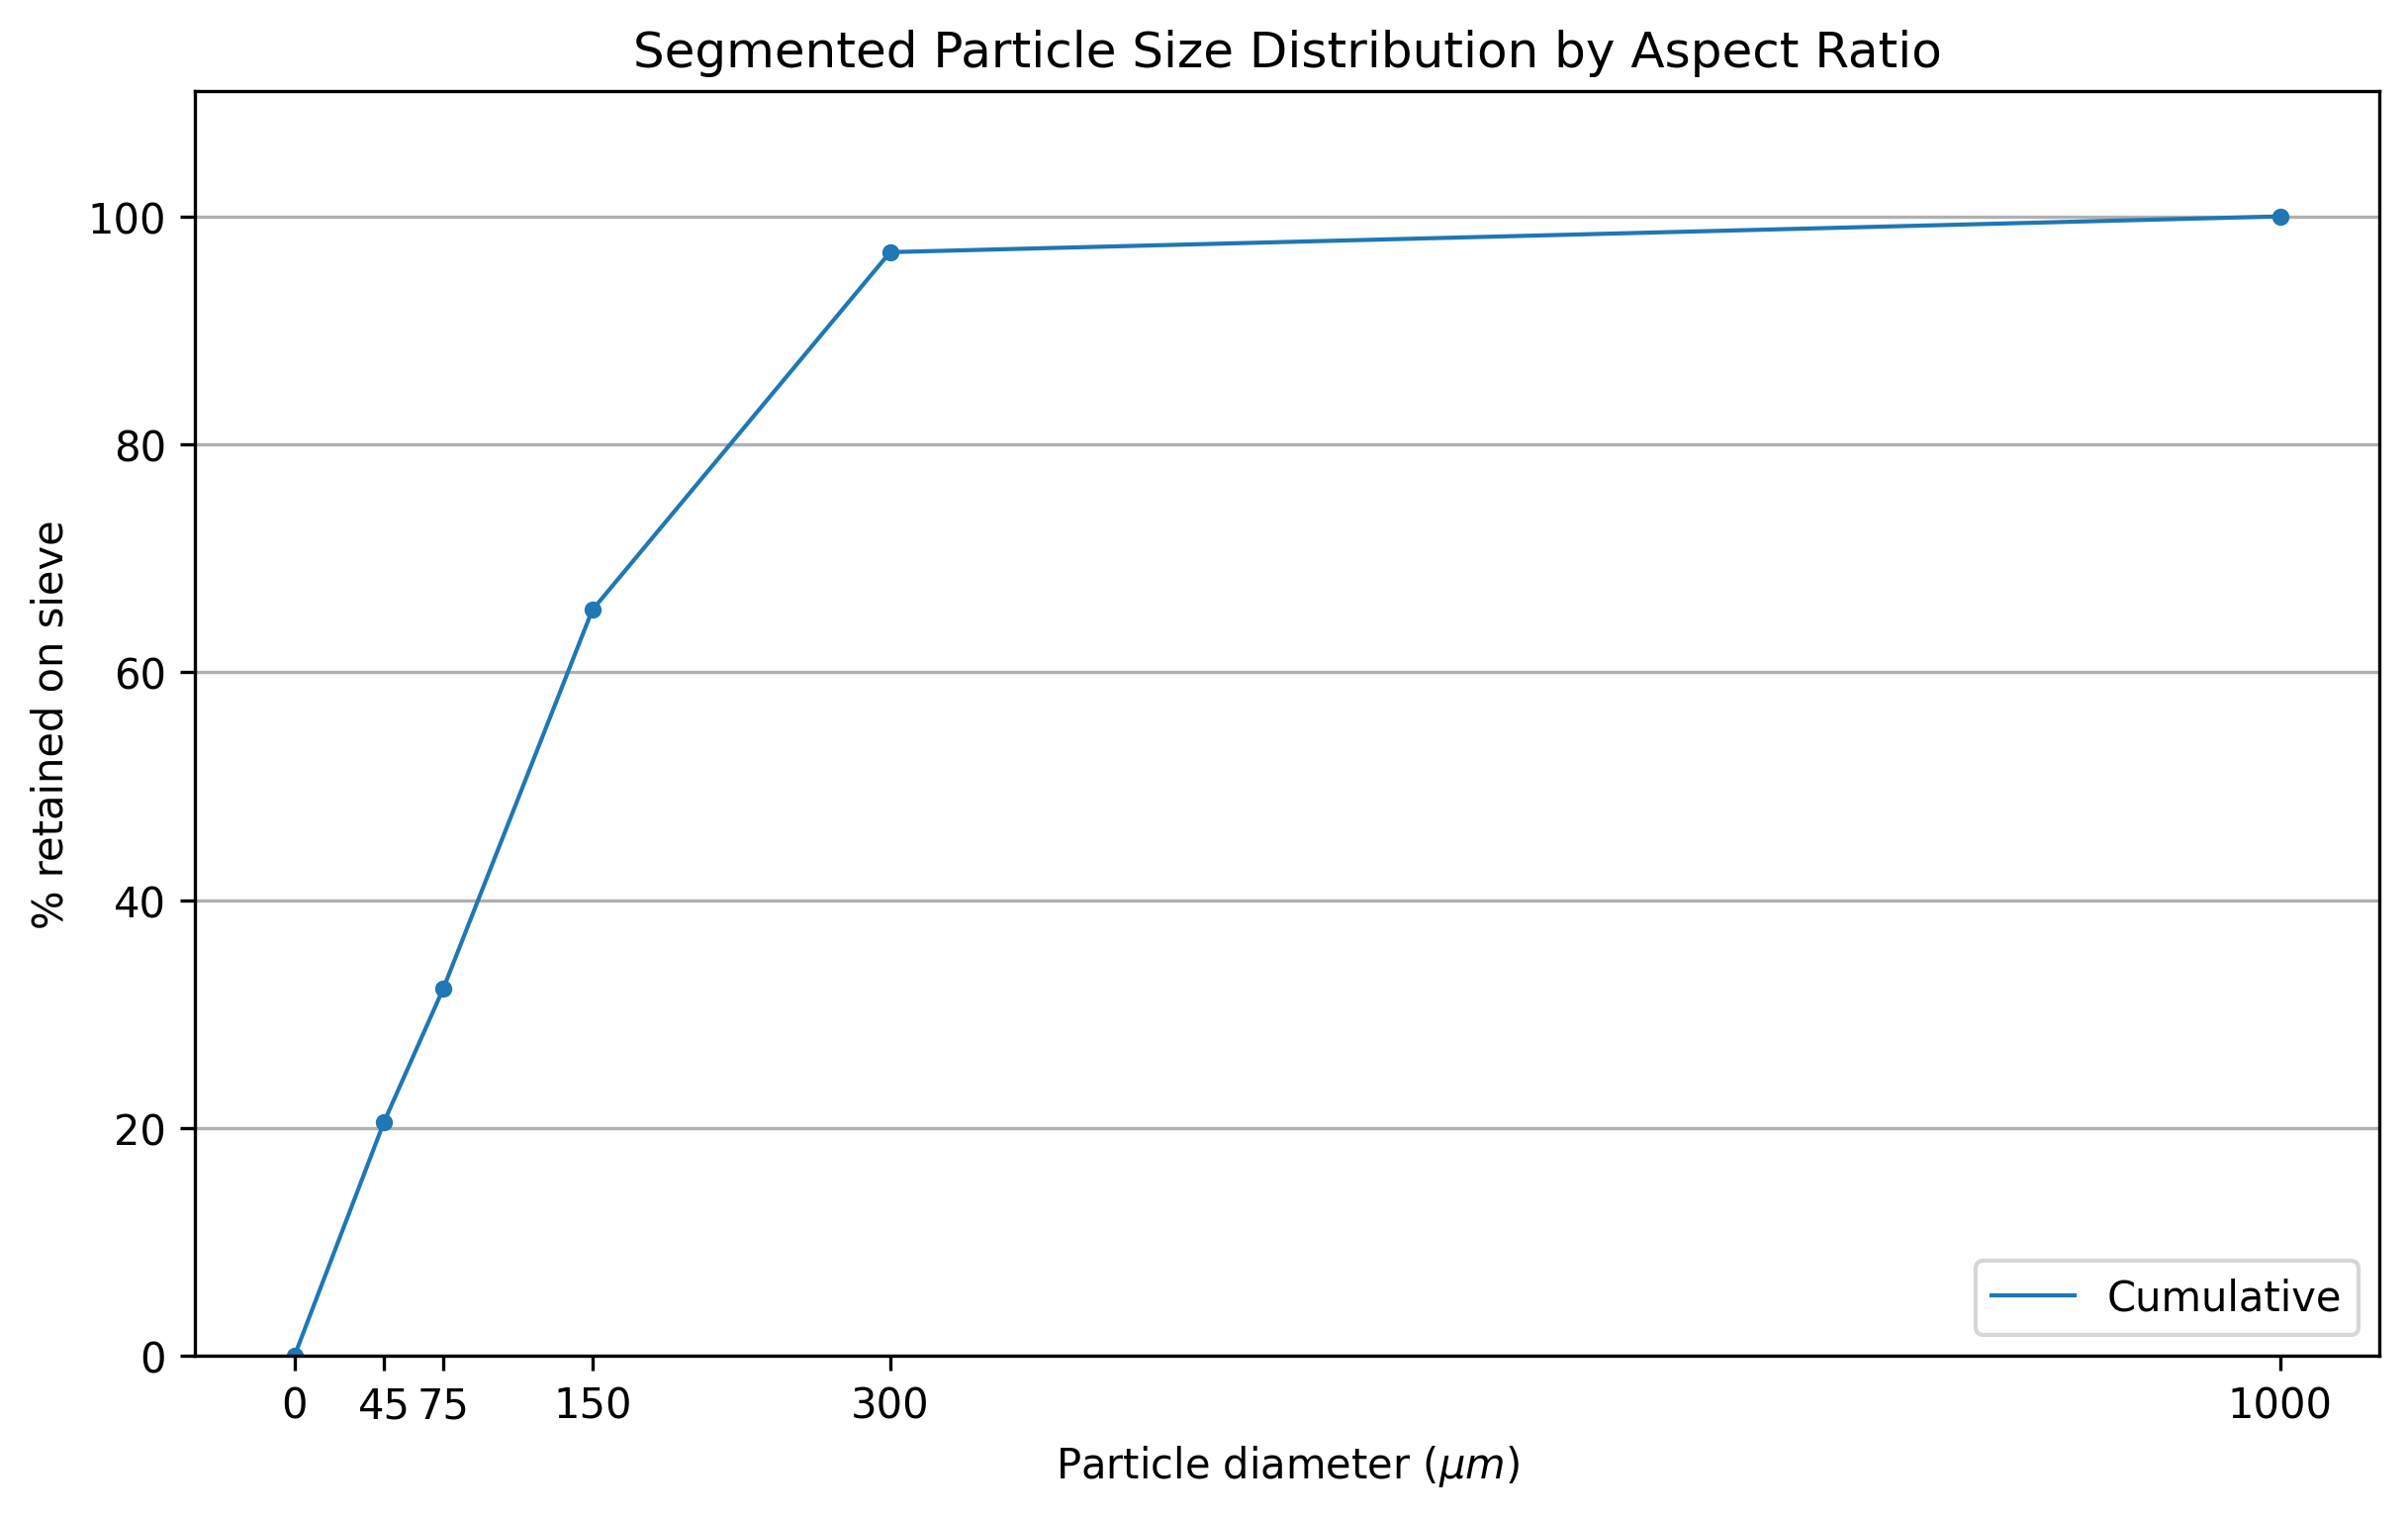

In [22]:
# Based on "Full Production" doc
bin_edges = np.array([0, 45, 75, 150, 300, 1000])
n_particles, sieve_sizes = simulate_sieve(imgs_labeled, bin_edges, pixel_res=8.434786)
fig, ax = grading_curve(n_particles, bin_edges)

   usa     um  pct-retained
8  270   53.0           0.0
7  200   75.0           0.2
6  140  106.0           3.0
5  100  150.0          15.0
4   70  212.0          37.0
3   50  300.0          34.0
2   40  425.0          10.5
1   30  600.0           0.3
0   20  850.0           0.0
diameter_ums=array([ 53.,  75., 106., 150., 212., 300., 425., 600., 850.])
diameter_ums.shape=(9,)
np.cumsum(f50_pct)=array([  0. ,   0.2,   3.2,  18.2,  55.2,  89.2,  99.7, 100. , 100. ])
np.cumsum(f50_pct).shape=(9,)


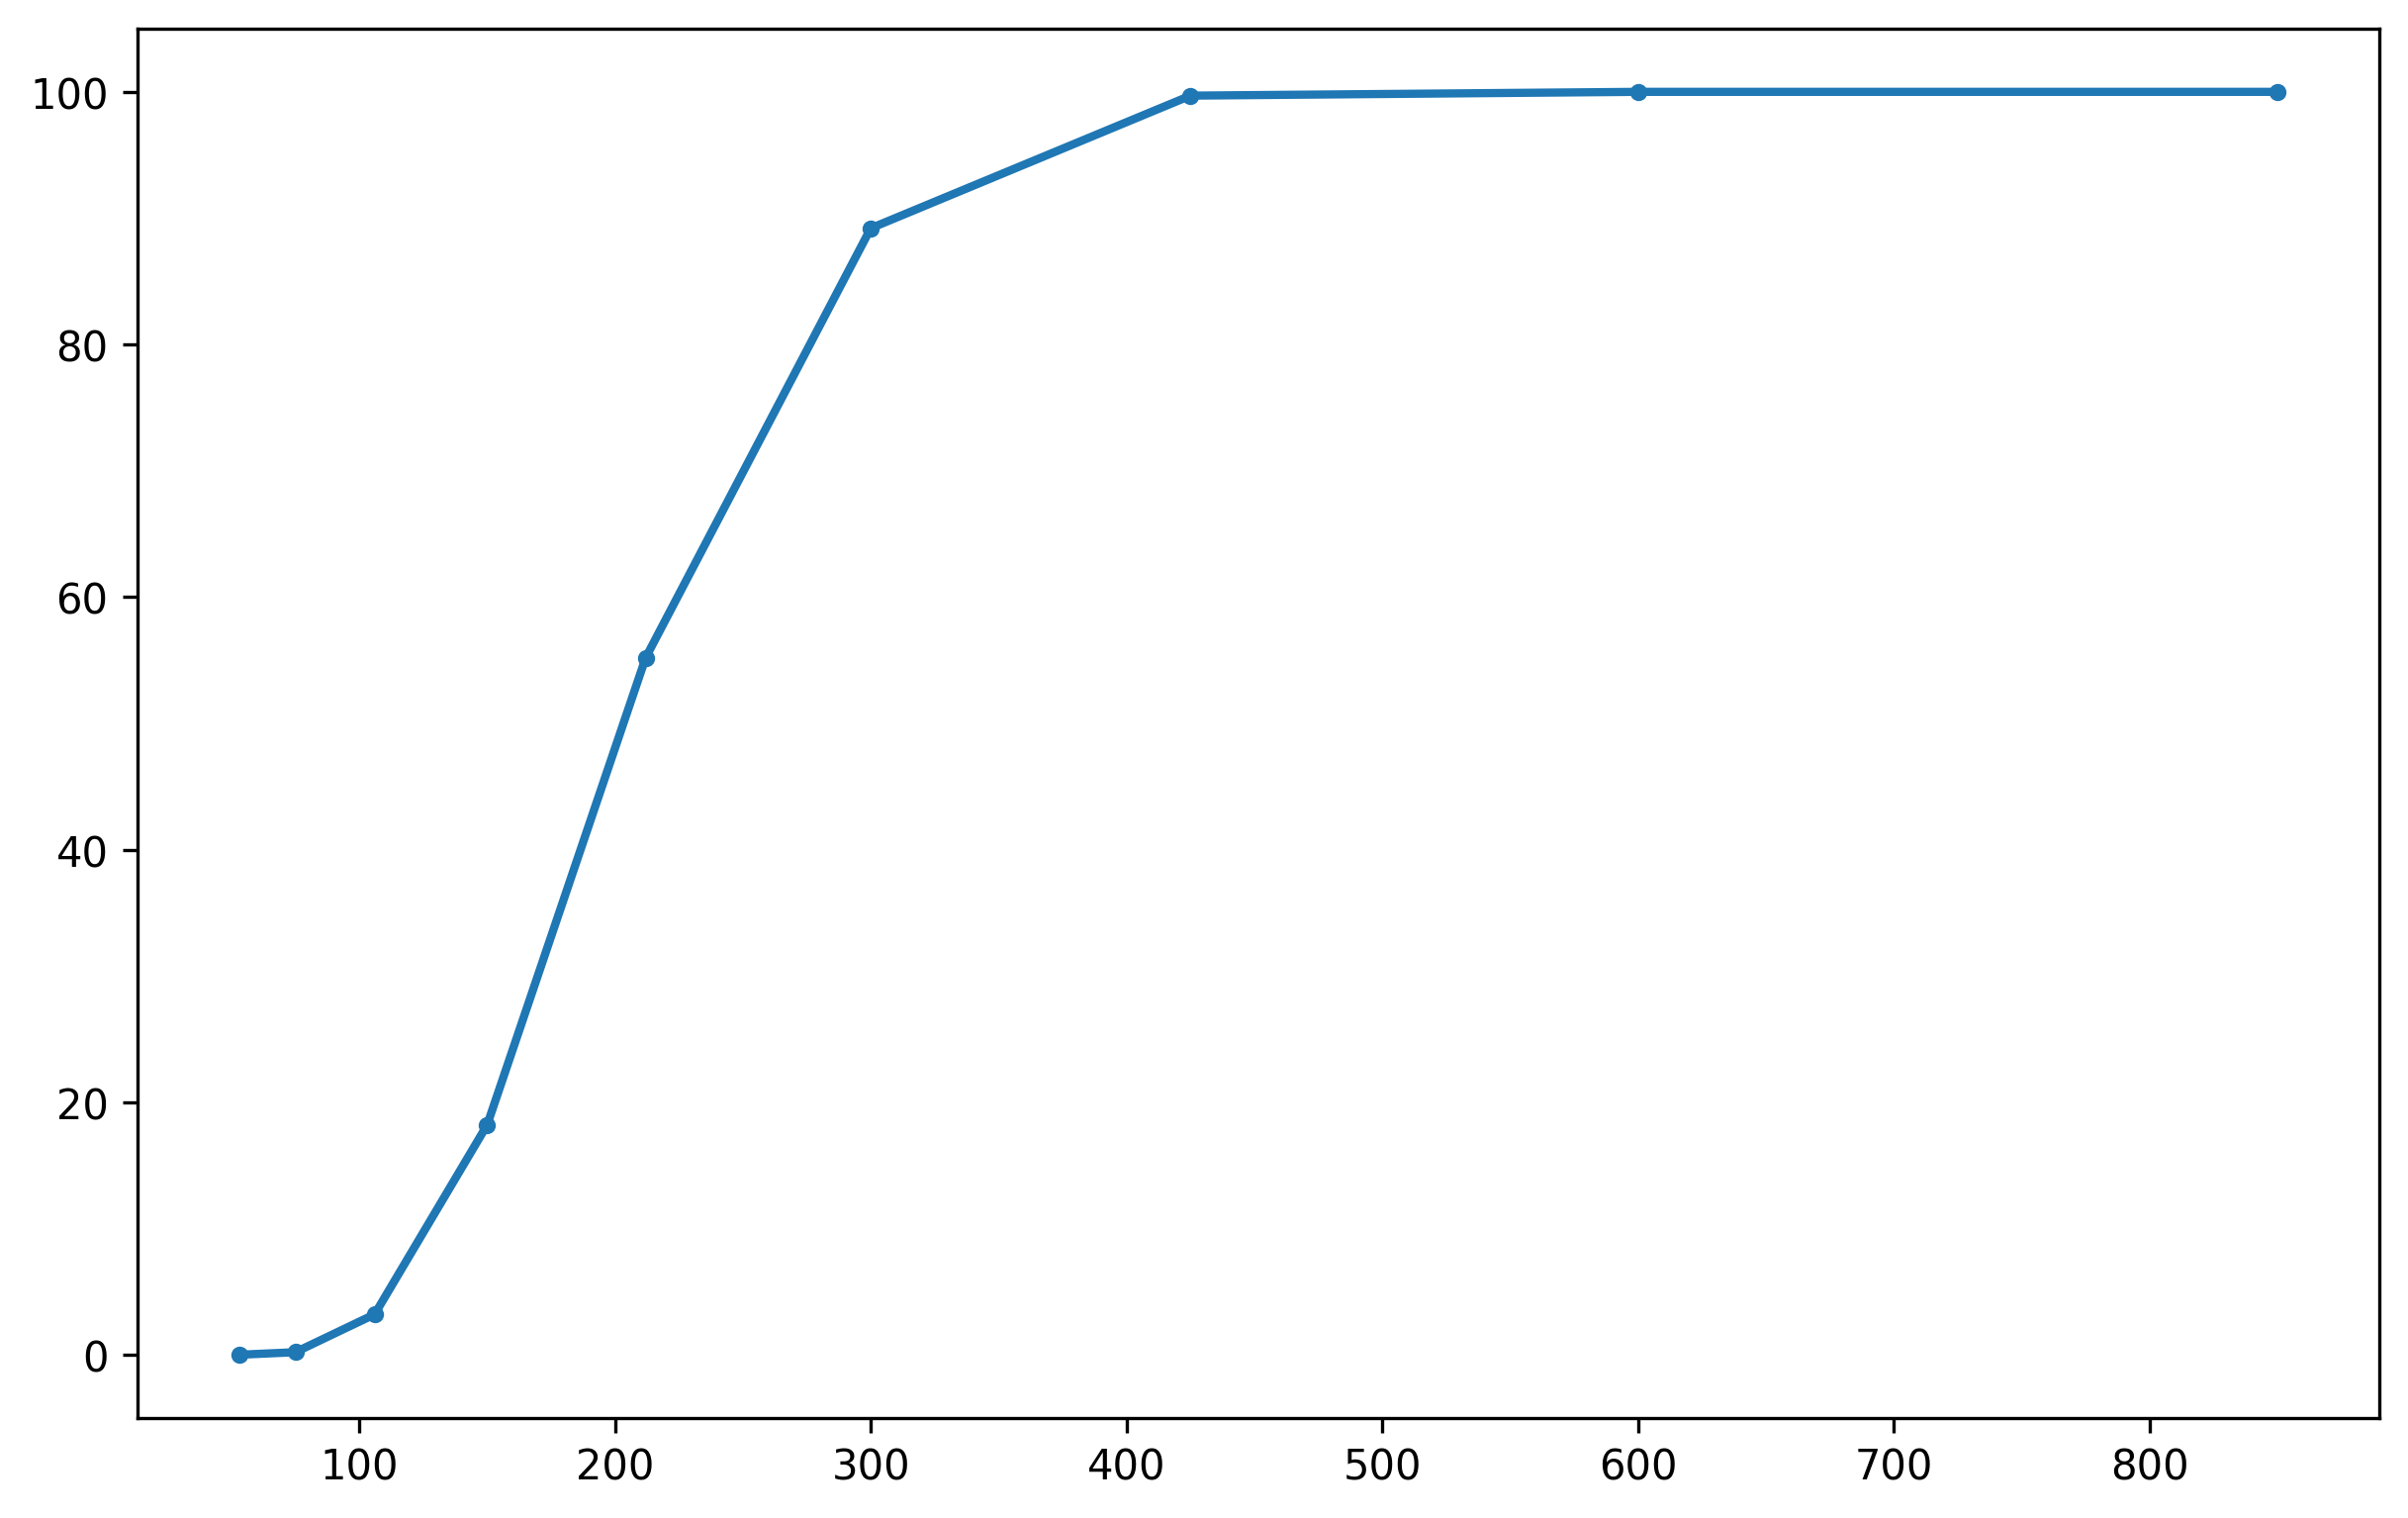

In [14]:
# Collect sieve data
sieve_df = pd.read_csv(
    Path('../data/F50-sieve.csv'), index_col=0).sort_values('um')
print(sieve_df)
diameter_ums = sieve_df.um.to_numpy()
f50_pct = sieve_df['pct-retained'].to_numpy()
# Plot histogram
fig, ax = plt.subplots(
    figsize=(8, 5), facecolor='white', constrained_layout=True, dpi=300)
x_pos = np.arange(f50_pct.shape[0])  # the label locations
print(f'{diameter_ums=}')
print(f'{diameter_ums.shape=}')
print(f'{np.cumsum(f50_pct)=}')
print(f'{np.cumsum(f50_pct).shape=}')
ax.scatter(diameter_ums, np.cumsum(f50_pct), s=10, zorder=3)
ax.plot(
    diameter_ums, np.cumsum(f50_pct), linewidth=2, zorder=3,
    label='F50 Standard'
)

(6,)
[   0   45   75  150  300 1000]
(5,)
[2788 1601 4517 4273  427]
(5,)
[20.49095987 11.76686756 33.19858886 31.40526238  3.13832133]
[ 20.49095987  32.25782743  65.45641629  96.86167867 100.        ]


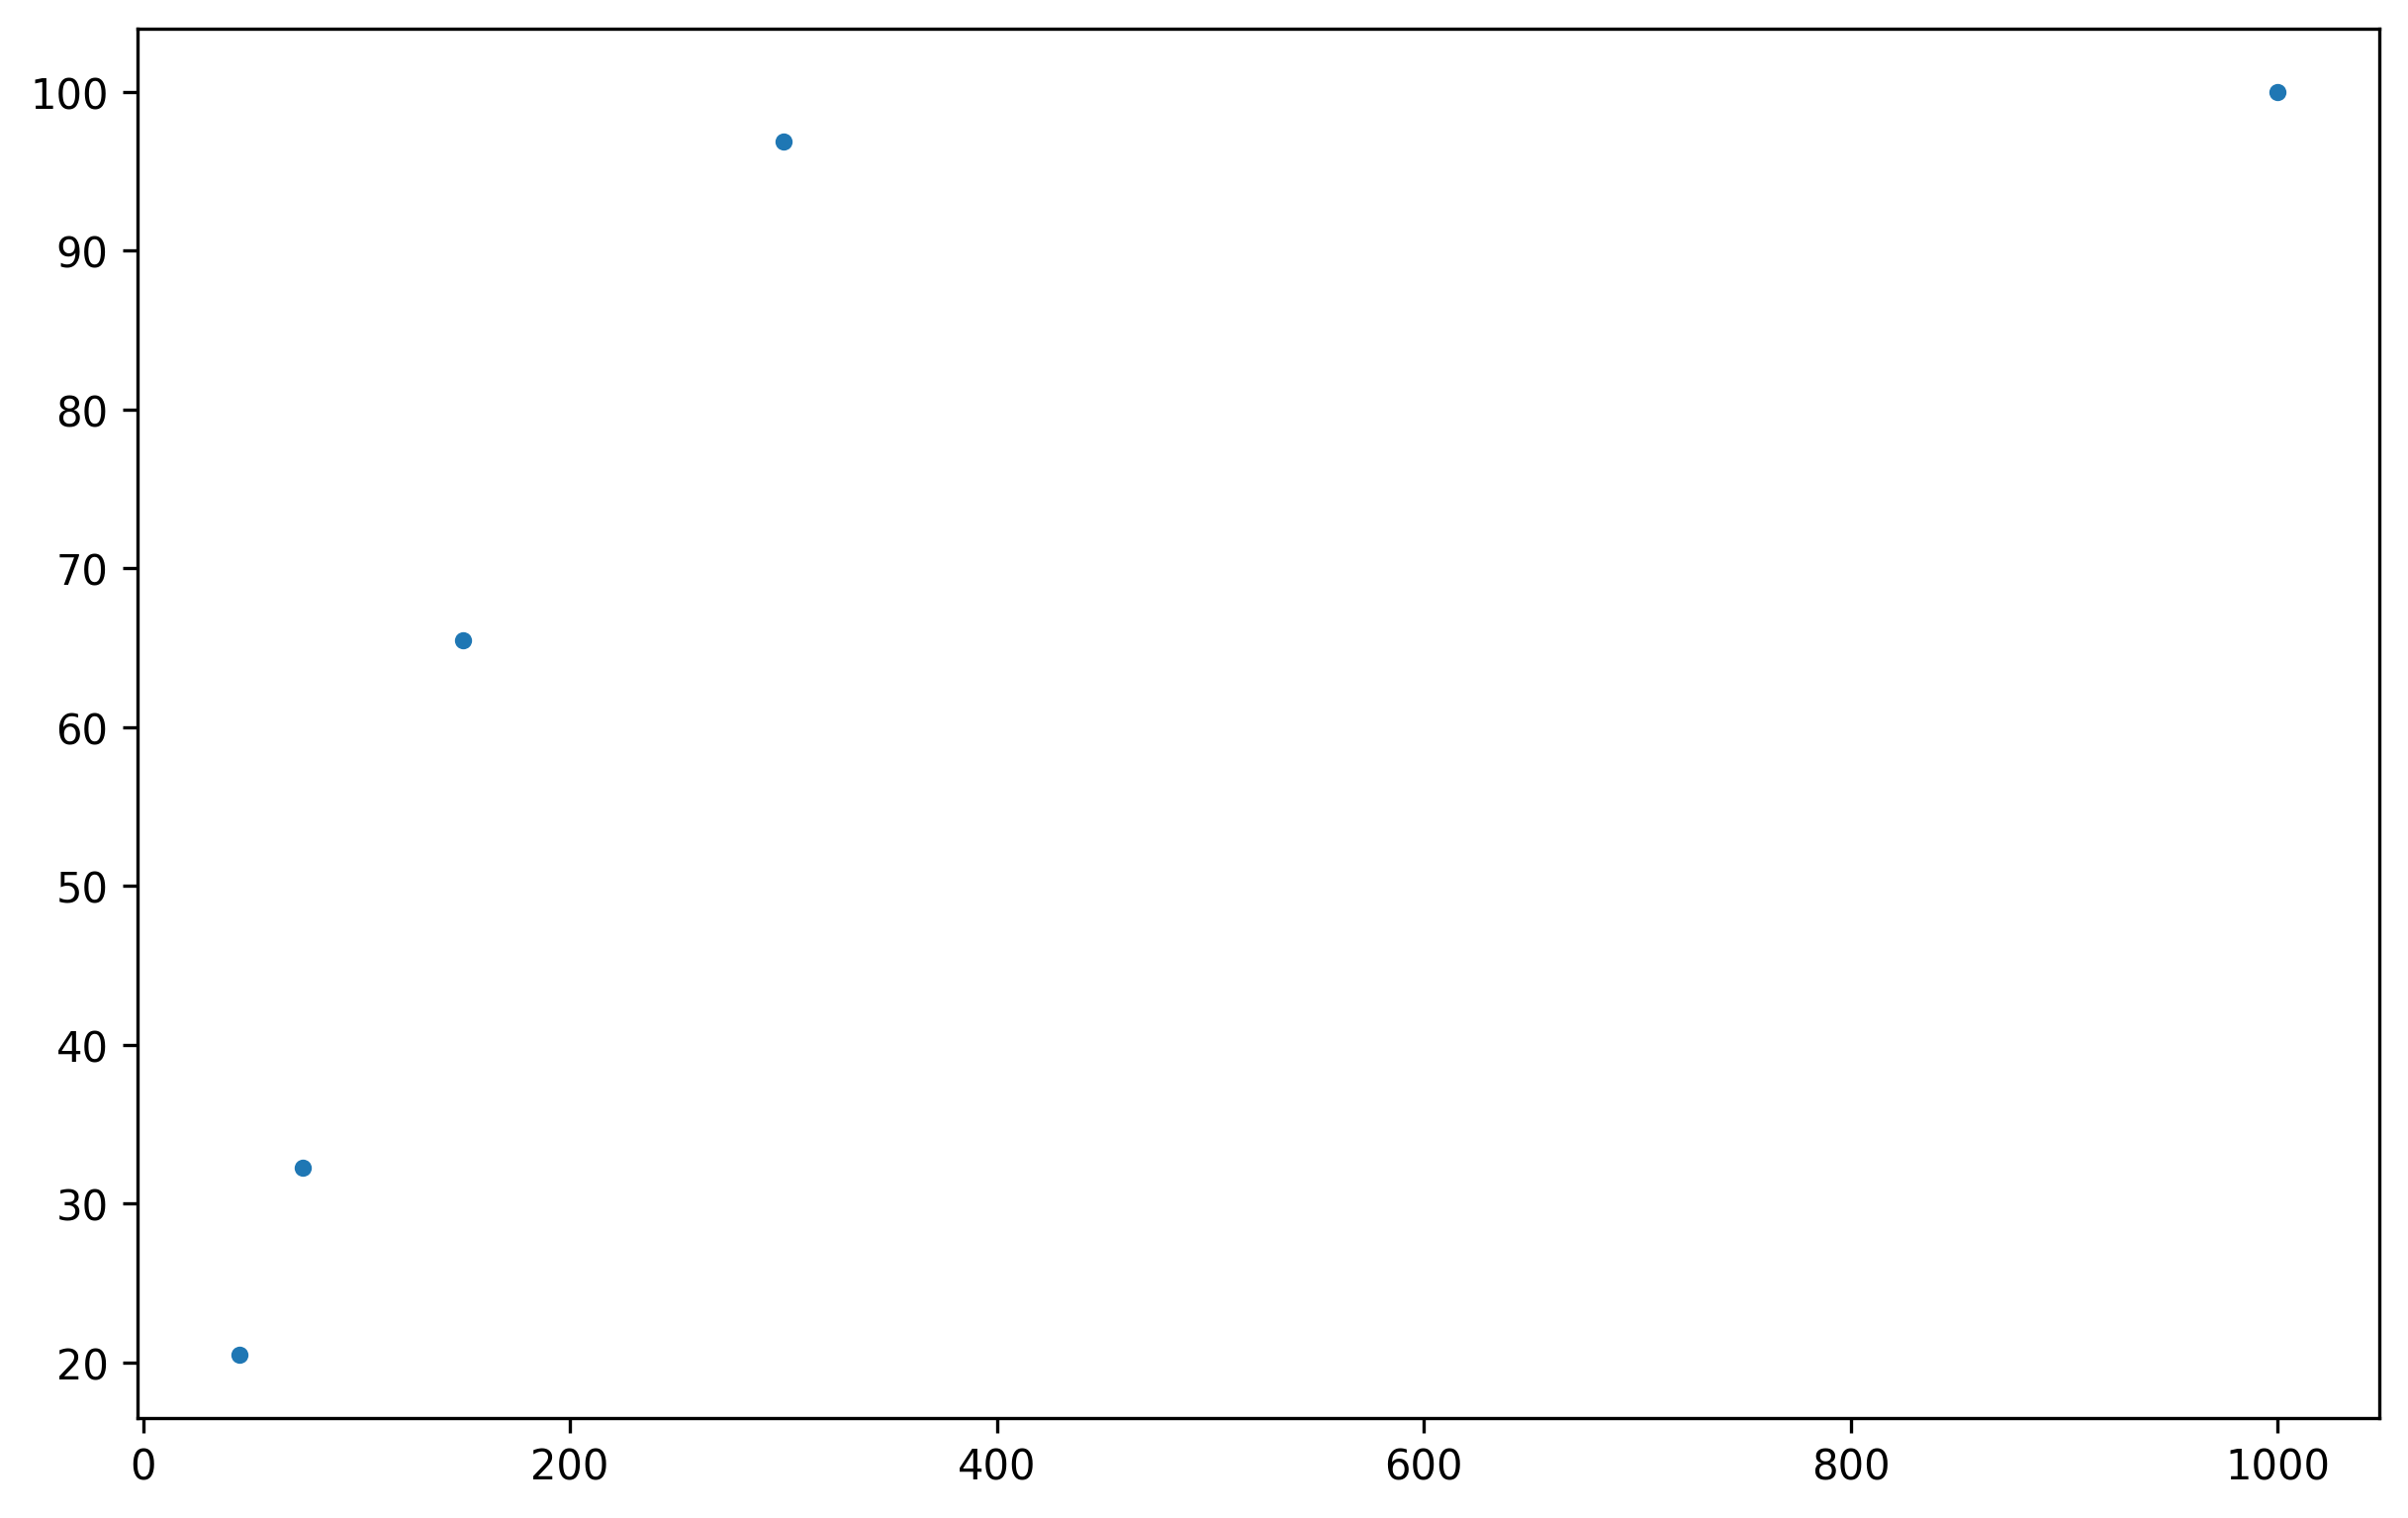

In [5]:
print(bin_edges.shape)
print(bin_edges)
print(hist.shape)
print(hist)
bins = bin_edges[1:]
hist_pct = 100 * hist / np.sum(hist)
print(hist_pct.shape)
print(hist_pct)
print(np.cumsum(hist_pct))
fig, ax = plt.subplots(
    figsize=(8, 5), facecolor='white', constrained_layout=True, dpi=300)
ax.scatter(bins, np.cumsum(hist_pct), s=10, zorder=2)

In [6]:
test = [10, 30, 30, 30, 60, 60, 60, 90, 90]
test_edges = [20, 50, 70]
test_bins = np.insert(test_edges, 0, 0)
hist, bins = np.histogram(test, bins=test_edges)
print(len(test))
print(bins)
print(hist)

9
[20 50 70]
[3 3]
